# Tests on Bandit with Non-Stationary Context Distribution
Here we will test the library [IS_non_stationary_RL](https://github.com/pierresdr/IS_non_stationary_RL) to evaluate and optimize the Non-Stationary Contextual Bandit.
The in the library is defined the custom environment with a non-stationary context distribution. The environment behaviour is explained at the beginning of [NS_contextual bandits.ipynb](./non-stat_contextual_bandits.ipynb), which contains different tests of similar environments.

In [2]:
# 'autoreload' allows to update modules without resetting the kernel 
%load_ext autoreload
%autoreload 2

In [3]:
# Import 'IS_Non-Stationary_RL' library
import sys
sys.path.append('../../IS_non_stationary_RL/')

from policy import Hyperpolicy, Policy
from env.contextual_bandits import ContextualBandit
from importance_sampling.mis_balance_heuristic import MIS_bh_grad, MIS_bh_estimation, MIS_bh_estimation_range, MIS_bh_variance, objective_estimate
from test_lib import play, replay, optimize
                        
from tqdm import tqdm
import argparse, logging
import numpy as np
import matplotlib.pyplot as plt
import scipy


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

 ## Define and test the optimal policy

In [7]:
def play_nu(nu, env, n_steps):

    contexts = np.zeros(n_steps)
    thetas   = np.zeros(n_steps)
    rewards  = np.zeros(n_steps)
    actions  = np.zeros(n_steps)
    non_stat_process = np.zeros(n_steps)
    theta_means      = np.zeros(n_steps)
    
    x_t = env.reset()
    for t in range(n_steps):
        
        policy = nu.sample_policy(t)

        contexts[t] = x_t
        thetas[t] = policy.theta
        
        # Perform a step sampling the action from current policy 
        action = policy.sample_action(x_t)
        x_t, r_t = env.step(action)
        
        rewards[t] = r_t
        actions[t] = action
        non_stat_process[t] = env.non_stat_process(t)
        theta_means[t] = nu.theta_mean(t)

    #return MIS_bh_estimation(nu, thetas, rewards, alpha=n_steps, beta=1)
    return contexts, thetas, rewards, actions, non_stat_process, theta_means

In [8]:
nu = Hyperpolicy(Policy, sigma_theta=1, A=4, psi=0, phi=0.1) 
env = ContextualBandit(mean_reward=True, sigma_x=2, A_x=4, psi_x=0, phi_x=0.1, 
                                         sigma_r=1, A_r=4, psi_r=0, phi_r=0.1) 

contexts, thetas, rewards, actions, non_stat_process, theta_means = play_nu(nu, env, 100)

plt.plot(contexts, label='context')
plt.plot(non_stat_process, label='context_mean')
plt.plot(thetas, label='thetas')
plt.legend()
plt.show()

plt.plot(actions)
plt.title('actions')
plt.show()

plt.plot(rewards)
plt.title('rewards')
plt.show()

AttributeError: 'ContextualBandit' object has no attribute 'non_stat_process'

## Test MIS estimator with BH

In [ ]:
### Compute average IS weights (t=251 for 0, t=236 for max)
t = 236
alpha = t
replicas = 10
all_IS_weights = np.zeros((replicas, alpha))

# Initialize hyperpolicy and env
nu = Hyperpolicy(Policy, sigma_theta=1, A=3, psi=0, phi=0.1) 
env = ContextualBandit(mean_reward=True, sigma_x=1, A=3, psi=0, phi=0.1) 

for i in tqdm(range(replicas)):    
    
    env.reset()
    contexts, thetas, rewards, actions, NS_process, theta_means = env.play(nu, n_steps=t, get_p=get_p)
    
    # Evaluate the performance 
    all_IS_weights[i] = MIS_bh_estimation(nu, thetas, rewards, alpha, beta=1)[0]

## MIS as a function of A (of both env and nu)
Now that the context are sampled from the non-stat distribution, the optimal policy needs to 

In [181]:
#### Problem settings ####
param_based = True
R_inf = 1
alpha = 126
range_A = np.linspace(1,5,20)
#A_sigma_ratios = np.linspace(0.1,3,30)
n_seeds = 15
##########################

perf_NS = []
perf_MIS = []
var_MIS = []

for A in tqdm(range_A):
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    nu = Hyperpolicy(Policy, sigma_theta=1, A=A, psi=0, phi=0.1) 
    env = ContextualBandit(mean_reward=True, sigma_x=2, A=A, psi=0, phi=0.1) 

    for s in range(n_seeds):
        
        env.reset()
        contexts, thetas, rewards, actions, NS_process, theta_means = play_nu(nu, env, alpha)
        
        temp_perf_NS.append(np.mean(rewards[-alpha:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, alpha, beta=1)[1]*alpha)
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, R_inf, alpha, beta=1))
        
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)

100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


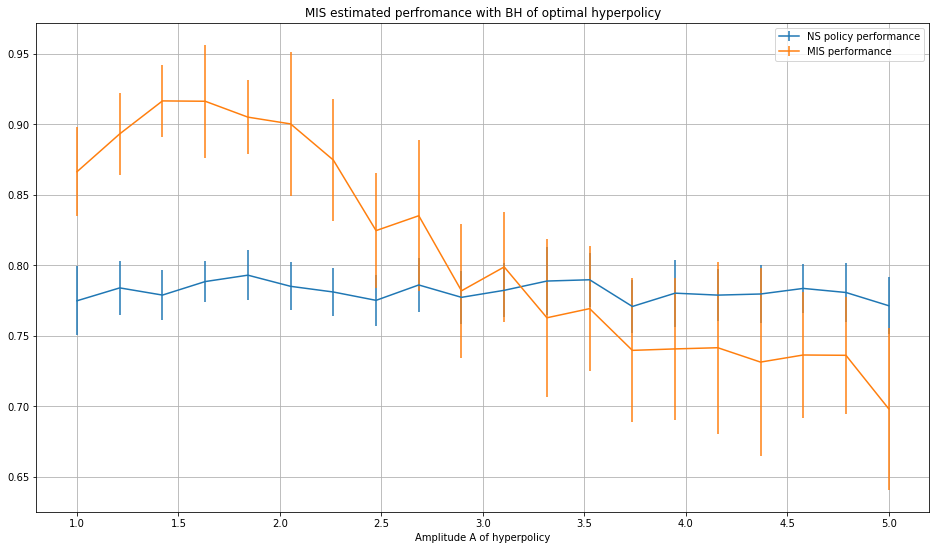

In [184]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(range_A, perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(range_A, perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
#ax.errorbar(range_A, var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')
ax.grid()
ax.set_xlabel('Amplitude A of hyperpolicy')
ax.legend()
plt.title('MIS estimated perfromance with BH of optimal hyperpolicy')
plt.show()

## MIS as a function of sigma theta

In [185]:
#### Problem settings ####
param_based = True
R_inf = 1
alpha = 126
range_sigma = np.linspace(0.1,4,20)
#A_sigma_ratios = np.linspace(0.1,3,30)
n_seeds = 20
##########################

perf_NS = []
perf_MIS = []
var_MIS = []

for sigma in tqdm(range_sigma):
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    nu = Hyperpolicy(Policy, sigma_theta=sigma, A=5, psi=0, phi=0.1) 
    env = ContextualBandit(mean_reward=True, sigma_x=2, A=5, psi=0, phi=0.1) 

    for s in range(n_seeds):
        
        env.reset()
        contexts, thetas, rewards, actions, NS_process, theta_means = play_nu(nu, env, alpha)
        
        temp_perf_NS.append(np.mean(rewards[-alpha:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, alpha, beta=1)[1]*alpha)
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, R_inf, alpha, beta=1))
        
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)

100%|██████████| 20/20 [00:40<00:00,  2.01s/it]


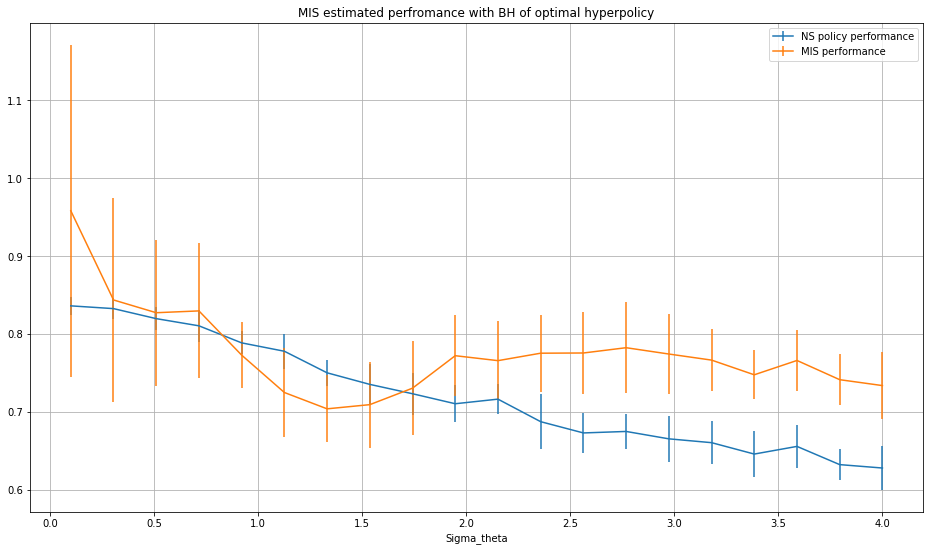

In [186]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(range_sigma, perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(range_sigma, perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
#ax.errorbar(range_sigma, var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')
ax.grid()
ax.set_xlabel('Sigma_theta')
ax.legend()
plt.title('MIS estimated perfromance with BH of optimal hyperpolicy')
plt.show()

# Test new environment
we have two different non-stationary process (one for the context mean and one for the reward term). Combining them we can obtain any version of Non-stationary contextual bandits environment:
 - $\mu_x = \mu_r$ is the first approach with Non-Stat context distibution
 - $\mu_x=0$ is the second approach with Non-Stat reward function
 - $\mu_x=0$ and $\sigma_x=0$ Context is always equal to zero, thus it is removed 

In [93]:
hyperpolicy_param = {
    'A_theta': 3,
    'B_theta': 0,
    'phi_theta': 0.2,
    'psi_theta': 0,
    'sigma_theta': 0.1,
}

# Define environment parameters (start with no context)
args = {
    'sigma_x': 0, 
    'A_x': 0, 
    'psi_x': 0, 
    'phi_x': 0, 
    
    'A_r': 1, 
    'psi_r': 0, 
    'phi_r': 0.2,
    
    'mean_reward': True,
}

args = {
    'n_steps': 200, 
    'sigma_x': 0, 
    'sigma_theta': 1, 
    'A_x': 0, 
    'A_theta': 3, 
    'A_r': 1, 
    'psi_x': 0, 
    'psi_theta': 0, 
    'psi_r': 0, 
    'phi_x': 0, 
    'phi_theta': 0.2,
    'phi_r': 0.2,
    
    'mean_reward': True,
}

contexts, thetas, rewards, actions, non_stat_process_x, non_stat_process_r, theta_means, nu = play(**args)

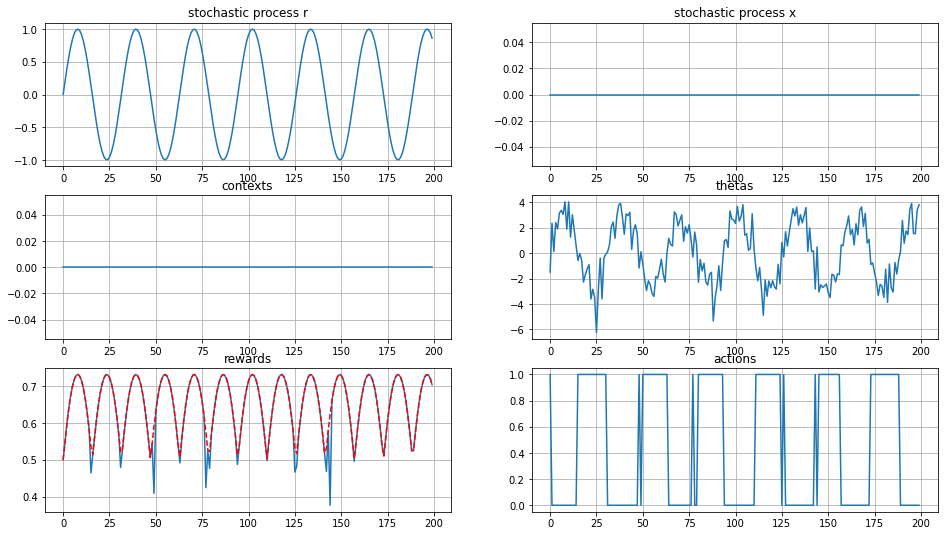

In [94]:
r_sigmoid = sigmoid(non_stat_process_x - non_stat_process_r)
r_sigmoid = np.maximum(r_sigmoid, 1-r_sigmoid)

plots = {
    'stochastic process r': [non_stat_process_r],
    'stochastic process x': [non_stat_process_x],
    'contexts': [contexts],
    'thetas': [thetas],
    'rewards': [rewards, {'x':  r_sigmoid,
                             'c': 'r',
                             'linestyle': '--'
                            }],
    'actions': [actions]
}

fig, ax = plt.subplots(int(np.ceil(len(plots)/2)),2,figsize=(16,9))



for i, (key, value) in enumerate(plots.items()):
    for v in value:
        if isinstance(v, dict):
            x = v['x']
            del v['x']
            ax[i//2,i%2].plot(x,**v)
        else:
            ax[i//2,i%2].plot(v)
    ax[i//2,i%2].grid()
    ax[i//2,i%2].set_title(key)


plt.show()

## Evaluate randomness of rewards

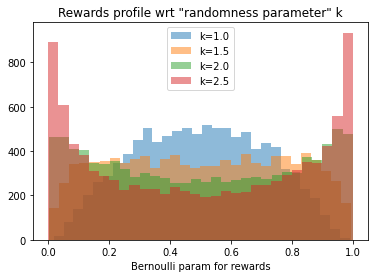

In [17]:
env = ContextualBandit(mean_reward=True, A_x=1, psi_x=0, phi_x=0.1,
                                         A_r=1, psi_r=0, phi_r=0.1, sigma_x=1) 

for k in np.arange(1,3,0.5):
    x = np.array([(env.sample_x(i)-env.non_stat_process_x(i))*k / env.sigma_x for i in range(10000)])
    plt.hist(sigmoid(x), bins=30, alpha=0.5, label='k='+str(k))

plt.title('Rewards profile wrt "randomness parameter" k')
plt.xlabel('Bernoulli param for rewards')
plt.legend()
plt.show()

# Evaluate MIS dependence wrt nu params
### MIS as a function of sigma_theta

In [18]:
args = {
    'n_steps': 200, 
    'sigma_x': 1, 
    'sigma_theta': 1, 
    'A_x': 2, 
    'A_theta': 2, 
    'A_r': 2, 
    'psi_x': 0, 
    'psi_theta': 0, 
    'psi_r': 0, 
    'phi_x': 0.1, 
    'phi_theta': 0.1,
    'phi_r': 0.1,
    
    'mean_reward': True,
}

est_args = {
    'R_inf': 1,
    'alpha': 120, 
    'n_seeds': 15,
    'range_sigma_theta': np.linspace(0.1,3,30),
}


perf_NS = []
perf_MIS = []
var_MIS = []

for sigma in tqdm(est_args['range_sigma_theta']):
    args['sigma_theta'] = sigma
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    for s in range(est_args['n_seeds']):
        contexts, thetas, rewards, actions, non_stat_process_x, non_stat_process_r, theta_means, nu = play(**args)
        temp_perf_NS.append(np.mean(rewards[-est_args['alpha']:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, est_args['alpha'], beta=1)[0])
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, est_args['R_inf'], est_args['alpha'], beta=1))
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)


100%|██████████| 30/30 [00:46<00:00,  1.56s/it]


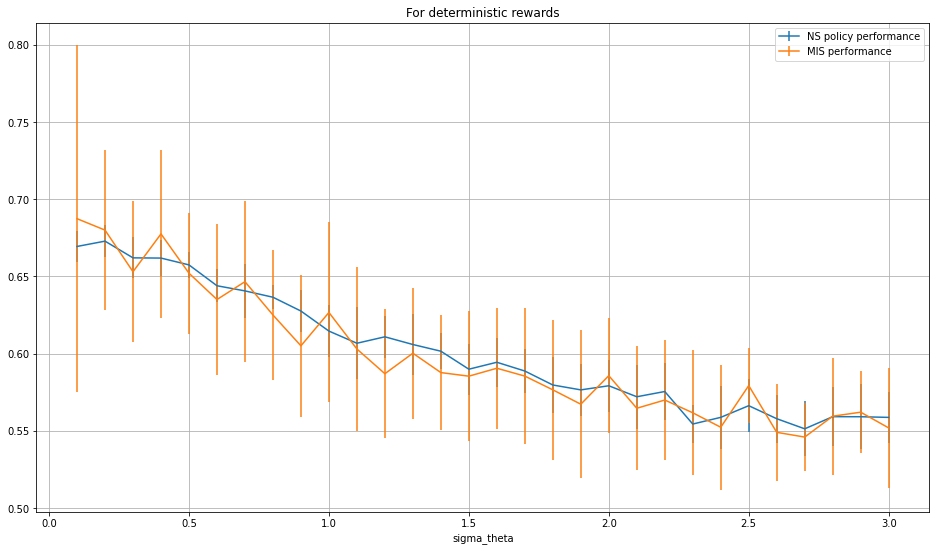

In [19]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(est_args['range_sigma_theta'], perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(est_args['range_sigma_theta'], perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
#ax.errorbar(est_args['range_sigma_theta'], var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')
ax.grid()
ax.set_xlabel('sigma_theta')
ax.set_title('For deterministic rewards')
ax.legend()

### MIS as a function of A_theta

In [35]:
args = {
    'n_steps': 200, 
    'sigma_x': 1, 
    'sigma_theta': 1, 
    'A_x': 5, 
    'A_theta': 1, 
    'A_r': 5, 
    'psi_x': 0, 
    'psi_theta': 0, 
    'psi_r': 0, 
    'phi_x': 0.1, 
    'phi_theta': 0.1,
    'phi_r': 0.1,
    
    'mean_reward': True,
}

est_args = {
    'R_inf': 1,
    'alpha': 120, 
    'n_seeds': 15,
    'range_A_theta': np.linspace(0.1,10,30),
}


perf_NS = []
perf_MIS = []
var_MIS = []

for A_theta in tqdm(est_args['range_A_theta']):
    args['A_theta'] = A_theta
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    for s in range(est_args['n_seeds']):
        contexts, thetas, rewards, actions, non_stat_process_x, non_stat_process_r, theta_means, nu = play(**args)
        temp_perf_NS.append(np.mean(rewards[-est_args['alpha']:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, est_args['alpha'], beta=1)[0])
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, est_args['R_inf'], est_args['alpha'], beta=1))
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


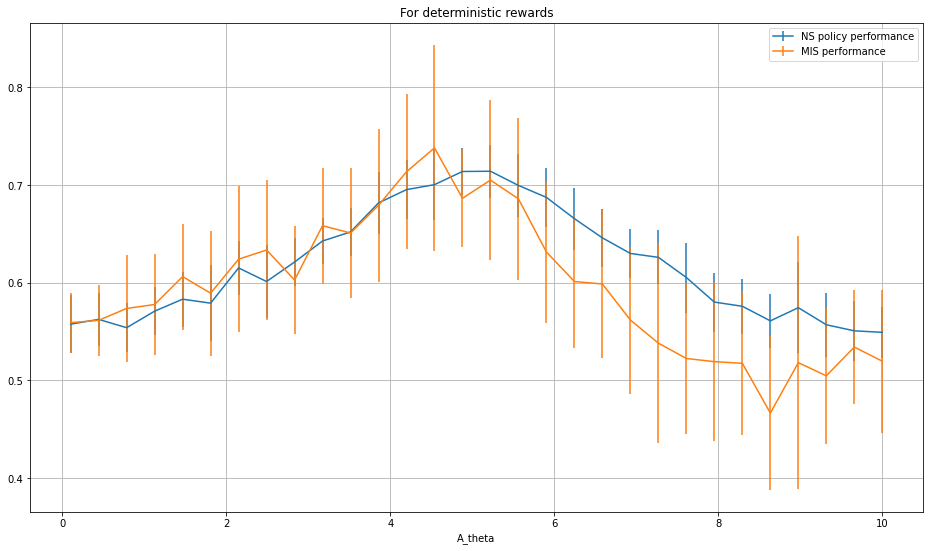

In [36]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(est_args['range_A_theta'], perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(est_args['range_A_theta'], perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
#ax.errorbar(est_args['range_A_theta'], var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')
ax.grid()
ax.set_xlabel('A_theta')
ax.set_title('For deterministic rewards')
ax.legend()

### MIS as a function of psi_theta

In [37]:
args = {
    'n_steps': 200, 
    'sigma_x': 1, 
    'sigma_theta': 1, 
    'A_x': 2, 
    'A_theta': 2, 
    'A_r': 2, 
    'psi_x': np.pi, 
    'psi_theta': 0, 
    'psi_r': np.pi, 
    'phi_x': 0.1, 
    'phi_theta': 0.1,
    'phi_r': 0.1,
    
    'mean_reward': True,
}



est_args = {
    'R_inf': 1,
    'alpha': 120, 
    'n_seeds': 20,
    'range_psi': np.linspace(0,2*np.pi,30),
}


perf_NS = []
perf_MIS = []
var_MIS = []

for psi in tqdm(est_args['range_psi']):
    args['psi_theta'] = psi
    #args['psi_r'] = psi
    #args['psi_x'] = psi
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    for s in range(est_args['n_seeds']):
        contexts, thetas, rewards, actions, non_stat_process_x, non_stat_process_r, theta_means, nu = play(**args)
        temp_perf_NS.append(np.mean(rewards[-est_args['alpha']:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, est_args['alpha'], beta=1)[0])
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, est_args['R_inf'], est_args['alpha'], beta=1))
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)




100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


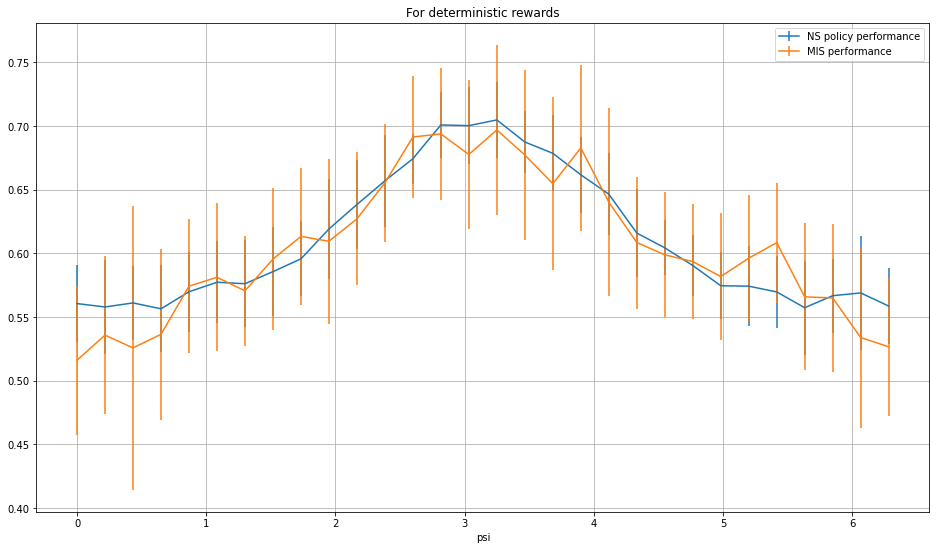

In [38]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(est_args['range_psi'], perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(est_args['range_psi'], perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
#ax.errorbar(est_args['range_psi'], var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')

ax.grid()
ax.set_xlabel('psi')
ax.set_title('For deterministic rewards')
ax.legend()

### MIS as a function of phi_theta

In [15]:
args = {
    'n_steps': 200, 
    'sigma_x': 0, 
    'sigma_theta': 1, 
    'A_x': 0, 
    'A_theta': 1, 
    'A_r': 1, 
    'psi_x': 0, 
    'psi_theta': 0, 
    'psi_r': 0, 
    'phi_x': 0.2, 
    'phi_theta': 0.1,
    'phi_r': 0.2,
    
    'mean_reward': True,
}



est_args = {
    'R_inf': 1,
    'alpha': 120, 
    'n_seeds': 20,
    'range_phi': np.linspace(0.1,0.3,30),
}


perf_NS = []
perf_MIS = []
var_MIS = []

for phi in tqdm(est_args['range_phi']):
    args['phi_theta'] = phi
    #args['phi_r'] = phi
    #args['phi_x'] = phi
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    for s in range(est_args['n_seeds']):
        contexts, thetas, rewards, actions, non_stat_process_x, non_stat_process_r, theta_means, nu = play(**args)
        temp_perf_NS.append(np.mean(rewards[-est_args['alpha']:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, est_args['alpha'], beta=1)[0])
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, est_args['R_inf'], est_args['alpha'], beta=1))
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)

100%|██████████| 30/30 [00:56<00:00,  1.87s/it]


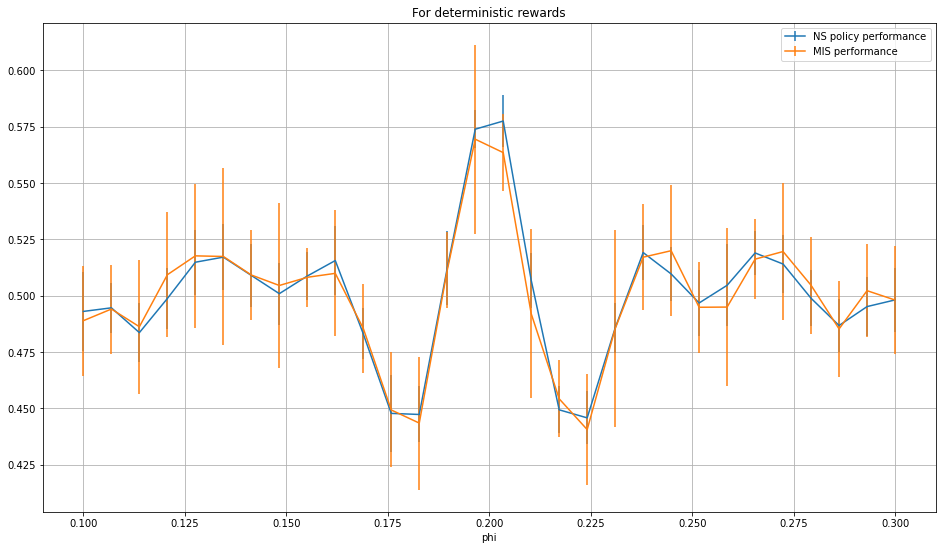

In [16]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(est_args['range_phi'], perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(est_args['range_phi'], perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
ax.grid()
ax.set_xlabel('phi')
ax.set_title('For deterministic rewards')
ax.legend()

phi seems to be the hardest parameter to learn, since the correct frequency (i.e. max performance) is inside two local minima of performance

# OPTIMIZATION TESTS
Let's start by optimizing the simplest case, the one without context. Start by collecting alpha rewards and then optimizing the hyperpolicy keeping fixed the current t

In [30]:
# args are used just to collect contexts using 'play()'
args = {
    'n_steps': 200, 
    
    'sigma_x': 0, 
    'sigma_theta': 1, 
    'sigma_r': 1, 
    
    'A_x': 1, 
    'A_theta': 1, 
    'A_r': 1, 
    
    'phi_x': 0, 
    'phi_theta': 0.1,
    'phi_r': 0.1,
    
    'psi_x': 0, 
    'psi_theta': 0, 
    'psi_r': 0, 
    
    'mean_reward': True,
}


contexts, _, _, _, _, _, _, _ = play(**args)


# Parameters of the hyperpolicy that will be optimized
optim_params = {
    'A_theta': 3,
    'phi_theta': 0.1,
    'psi_theta': 0,
    'B_theta': 0,
    'sigma_theta': 1,
    
    'learning_rate': 1e-3,
    'lamb_J_1': 1,
    'lamb_J_2': 0,
    'lamb_v': 0,
    
    'n_steps': 200,
    'alpha': 180,
    'n_steps_optim': 100,
}

nu = Hyperpolicy(Policy, A=optim_params['A_theta'], phi=optim_params['phi_theta'], 
                 psi=optim_params['psi_theta'], sigma_theta=optim_params['sigma_theta']) 
env = ContextualBandit(mean_reward=args['mean_reward'], A_x=args['A_x'], psi_x=args['psi_x'], phi_x=args['phi_x'],
                       A_r=args['A_r'], psi_r=args['psi_r'], phi_r=args['phi_r'], sigma_x=args['sigma_x']) 

t = len(contexts)

# Optimize params to perform better during this t
param_opt = np.zeros((optim_params['n_steps_optim'],4))
rewards_opt = np.zeros((optim_params['n_steps_optim'],optim_params['alpha']))
obj_values = np.zeros(optim_params['n_steps_optim'])

for i in tqdm(range(optim_params['n_steps_optim'])):
    nu, rewards, thetas, actions = optimize(contexts[t-optim_params['alpha']:], nu, env, t, n_steps=1,
                                            lamb_J_1=optim_params['lamb_J_1'], lamb_J_2=optim_params['lamb_J_2'], 
                                            lamb_v=optim_params['lamb_v'], lr=optim_params['learning_rate'],  R_inf=1, 
                                            alpha=optim_params['alpha'], beta=1)
    param_opt[i] = nu.get_params()
    rewards_opt[i] = rewards
    obj_values[i] = objective_estimate(lamb_j_1=optim_params['lamb_J_1'], lamb_j_2=optim_params['lamb_J_2'], lamb_v=optim_params['lamb_v'],
                                       rewards=rewards, thetas=thetas, nu=nu, t=t, alpha=optim_params['alpha'])
    

100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


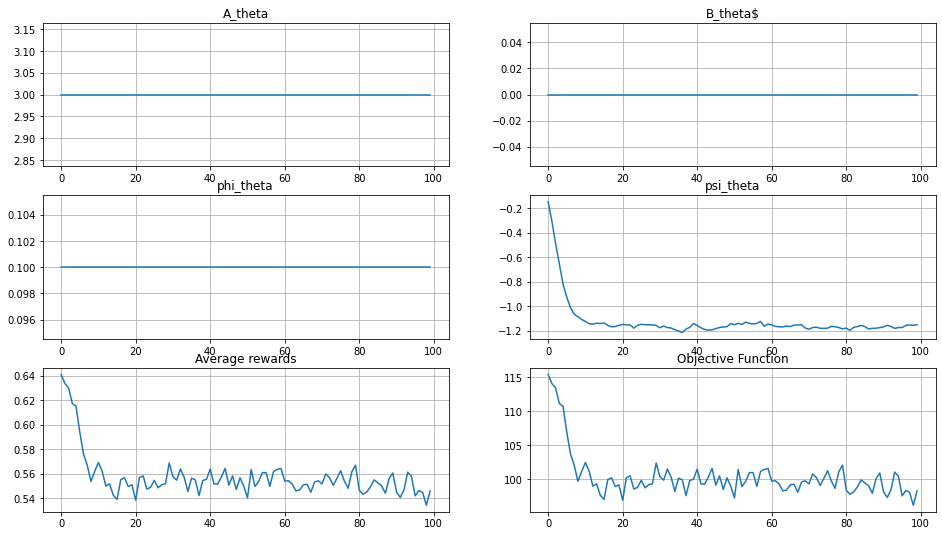

In [31]:
plots = {
    'A_theta': [param_opt[:,0]],
    'B_theta$': [param_opt[:,1]],
    'phi_theta': [param_opt[:,2]],
    'psi_theta': [param_opt[:,3]],
    'Average rewards': [rewards_opt.mean(axis=1)],
    'Objective Function': [obj_values]
}

fig, ax = plt.subplots(int(np.ceil(len(plots)/2)),2,figsize=(16,9))

for i, (key, value) in enumerate(plots.items()):
    for v in value:
        if isinstance(v, dict):
            x = v['x']
            del v['x']
            ax[i//2,i%2].plot(x,**v)
        else:
            ax[i//2,i%2].plot(v)
    ax[i//2,i%2].grid()
    ax[i//2,i%2].set_title(key)


plt.show()